# Explore The Dataset

Import Resources

In [1]:
import tensorflow as tf

print('\u2022 Using TensorFlow Version:', tf.__version__)

• Using TensorFlow Version: 2.2.0


Dyslexia Handwriting dataset

In [ ]:
import os
import zipfile

local_zip = 'Gambo.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('./data')
zip_ref.close()

Dataset was collected from 3 sources where uppercase letter is from NIST Special Database 19 [1] while lowercase letter is from Kaggle Dataset [2] and some datasets for testing is from dyslexic kids of Seberang Jaya primary school, Penang, Malaysia.
This dataset contains a total of 78275 for normal class while for reversal is 52196 and for corrected is 8029.
the dataset available on `Kagle` : `https://www.kaggle.com/datasets/drizasazanitaisa/dyslexia-handwriting-dataset`

Define of the data

In [2]:
base_dir = './data/Gambo'

train_dir = os.path.join(base_dir, 'Train')
validation_dir = os.path.join(base_dir, 'Test')

# Directory with our training cat/dog pictures
train_Corrected_dir = os.path.join(train_dir, 'Corrected')
train_Normal_dir = os.path.join(train_dir, 'Normal')
train_Reversal_dir = os.path.join(train_dir, 'Reversal')

# Directory with our validation cat/dog pictures
validation_Corrected_dir = os.path.join(validation_dir, 'Corrected')
validation_Normal_dir = os.path.join(validation_dir, 'Normal')
validation_Reversal_dir = os.path.join(validation_dir, 'Reversal')

Now, let's see what the filenames look like in the `Corrected`, `Normal` and `Reversal` `train` directories (file naming conventions are the same in the `validation` directory):

In [3]:
train_Corrected_fnames = os.listdir( train_Corrected_dir )
train_Normal_fnames = os.listdir( train_Normal_dir )
train_Reversal_fnames = os.listdir( train_Reversal_dir )

print(train_Corrected_fnames[:10])
print(train_Normal_fnames[:10])
print(train_Reversal_fnames[:10])

['4_1.png', '4_10.png', '4_100.png', '4_1000.png', '4_1001.png', '4_1002.png', '4_1003.png', '4_1004.png', '4_1005.png', '4_1006.png']
['A-0.png', 'A-1.png', 'A-10.png', 'A-1000.png', 'A-1001.png', 'A-1002.png', 'A-1004.png', 'A-1005.png', 'A-1006.png', 'A-1007.png']
['1_1.png', '1_10.png', '1_100.png', '1_1000.png', '1_10000.png', '1_10001.png', '1_10002.png', '1_10003.png', '1_10004.png', '1_10005.png']


Let's find out the total number of Corrected, Normal and Reversal images in the `train` and `validation` directories:

In [4]:
print('total training Corrected images :', len(os.listdir(      train_Corrected_dir ) ))
print('total training Normal images :', len(os.listdir(      train_Normal_dir ) ))
print('total training Reversal images :', len(os.listdir(      train_Reversal_dir ) ))

print('total validation Corrected images :', len(os.listdir( validation_Corrected_dir ) ))
print('total validation Normal images :', len(os.listdir( validation_Normal_dir ) ))
print('total validation Reversal images :', len(os.listdir( validation_Reversal_dir ) ))

total training Corrected images : 65534
total training Normal images : 39334
total training Reversal images : 46781
total validation Corrected images : 19284
total validation Normal images : 19557
total validation Reversal images : 17882


Now let's take a look at a few pictures to get a better sense of what the datasets look like. First, we configure the `matplotlib` parameters:

In [5]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 5
ncols = 5

pic_index = 0 # Index for iterating over images

Now, we display a batch of 6 Corrected, 6 Normal and 6 Reversal pictures. You can re-run the cell to see a fresh batch each time:

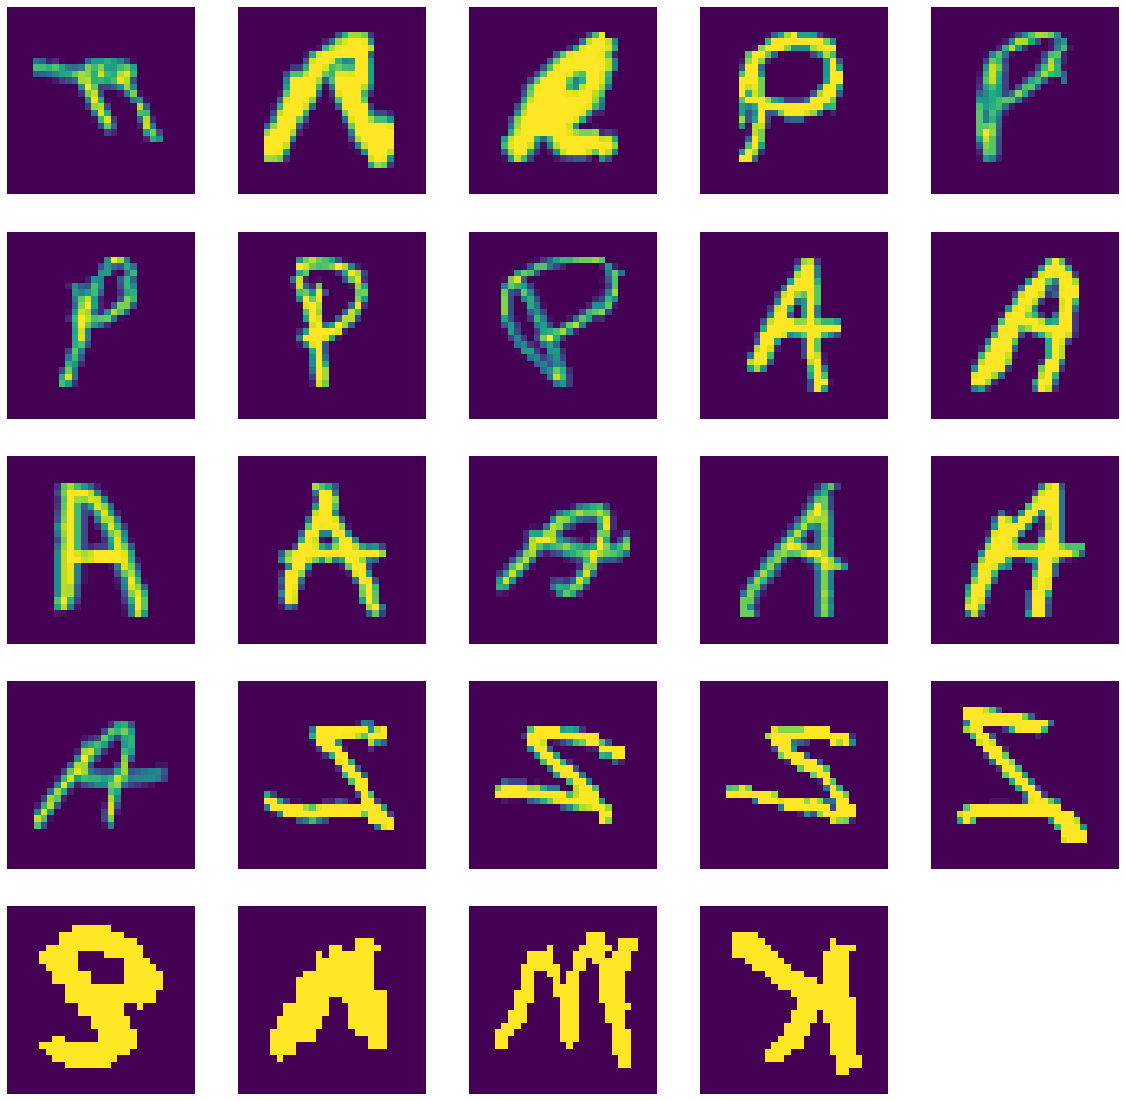

In [6]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_Corrected_pix = [os.path.join(train_Corrected_dir, fname) 
                for fname in train_Corrected_fnames[ pic_index-8:pic_index] 
               ]

next_Normal_pix = [os.path.join(train_Normal_dir, fname) 
                for fname in train_Normal_fnames[ pic_index-8:pic_index]
               ]
next_Reversal_pix = [os.path.join(train_Reversal_dir, fname) 
                for fname in train_Reversal_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_Corrected_pix+next_Normal_pix+next_Reversal_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

# Building the model

In [ ]:
# model = tf.keras.models.Sequential([
#     # Note the input shape is the desired size of the image 150x150 with 3 bytes color
#     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150,1)),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2), 
#     tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
#     tf.keras.layers.MaxPooling2D(2,2),
#     # Flatten the results to feed into a DNN
#     tf.keras.layers.Flatten(), 
#     # 512 neuron hidden layer
#     tf.keras.layers.Dense(256, activation='relu'), 
#     # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
#     tf.keras.layers.Dense(3, activation='softmax')  
# ])
# model.summary()

In [ ]:
# from tensorflow.keras.optimizers import RMSprop

# model.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0),
#               loss='binary_crossentropy',
#               metrics = ['accuracy'])

# Data Preprocessing

We rescale the images by dividing every pixel in the image by 255 to make them into range [0, 1]

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    #color_mode='grayscale',
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         #color_mode='grayscale',
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 151649 images belonging to 3 classes.
Found 56723 images belonging to 3 classes.


Callbacks

In [6]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') >= 98):
      print("\nReached 98% accuracy. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

Transfer learning

In [7]:
from tensorflow.keras.applications import Xception, VGG16, InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import pandas as pd

pre_trained_model= VGG16(input_shape=(150,150,3),
                        include_top=False)

for layer in pre_trained_model.layers:
    layer.trainable=False

#flatten layer
x= layers.Flatten()(pre_trained_model.output)
#fully connected layer
x= layers.Dense(1024, activation='relu')(x)
x= layers.Dropout(0.2)(x)
x= layers.Dense(1, activation='sigmoid')(x)

model= Model(pre_trained_model.input,x)
model.compile(optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy'])

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in pre_trained_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000000EDB93939D0>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC4B79340>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC4B6F820>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000000EDC4B6FA00>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC4B6FAF0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC47EEA00>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000000EDC4B20A60>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC4741BE0>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC47E5E50>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000000EDC4732A60>,block3_conv3,False


# Training

In [23]:
# base_dir = './data/Gambo'

# # train_dir = os.path.join(base_dir, 'Train')
# # validation_dir = os.path.join(base_dir, 'Test')

# train_len = 0
# for foldername in os.listdir(base_dir,'Train'):
#     train_len = train_len + len(os.listdir(os.path.join(base_dir,'Train',foldername)))
    
# val_len = 0
# for foldername in os.listdir(base_dir,'Test'):
#     val_len = val_len + len(os.listdir(os.path.join(base_dir,'Test',foldername)))

# print(train_len)
# print(val_len)

In [8]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              steps_per_epoch=(151649/1024), # 151649 adalah jumlah data gambar yg ada di folder train secara keseluruhan
                              epochs=3,
                              validation_steps=(56273/1024), #56273 adalah jumlah data gambar yg ada di folder test secara keseluruhan
                              callbacks=[callbacks],
                              verbose=1)

Epoch 1/3
149/148 [==============================] - 2800s 19s/step - loss: -180.0443 - accuracy: 0.3547 - val_loss: -557.2661 - val_accuracy: 0.3915
Epoch 2/3
 48/148 [========>.....................] - ETA: 30:48 - loss: -753.8195 - accuracy: 0.3724

: 

: 

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

# Save the model

In [ ]:
# EXERCISE: Save the trained model as a Keras HDF5 file. 
import time
saved_model_path = "./my_model.h5"

# YOUR CODE HERE
model.save(saved_model_path)